In [25]:
import os
import numpy as np
import pandas as pd
import re
from pandas.tseries.offsets import BMonthEnd
from dateutil.relativedelta import relativedelta
import pymssql
import beatbox
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline 

In [2]:
import seaborn as sns
sns.set_style('whitegrid')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import colorlover as cl
from IPython.display import HTML

In [3]:
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

from sklearn.linear_model import LogisticRegression

/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [4]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Helper function to plot confusion matrix to assess model results
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def get_confusion_matrix(actual_y, predicted_y):
    '''
    Helper function to nicely print confusion matrix
    '''
    confusion_index =  ['NotConverted-Actual','Converted-Actual']
    confusion_cols = ['NotConverted-Predicted','Converted-Predicted']
    confusion_df = pd.DataFrame(confusion_matrix(actual_y, predicted_y), index = confusion_index, columns = confusion_cols)
    return confusion_df

In [29]:
os.getcwd()
data_dir = '/Users/Gabi/Documents/projects/opps_model/similarity_model/data/'

In [6]:
%run 'loadvar.py'

In [12]:
%run 'title_functions.py'

In [185]:
# lead data
q = "select l.FirstName, l.LastName, l.Title, l.Title_Score__c, l.Job_Title_Match__c, l.email, "
q += "l.CreatedDate, l.IsConverted, l.CountryCode, l.CurrencyIsoCode, l.Number_of_Employees__c, "
q += "l.Department__c, l.Eloqua_Score_Card__c, l.Communication_Status__c, l.Community_Registered_User__c, "
q += "l.University_Registered_User__c, l.University_Steward__c, l.HasOptedOutofEmail, "
q+=  "l.Industry, l.Industry_Wave__c, l.Company, "
q += "l.Last_Responded_Campaign_Type__c, l.Last_Responded_Date__c, l.LastActivityDate, l.LastModifiedDate, l.Latest_Campaign__c, "
q += "l.Lead_Type__c, l.LeadSource, l.LeanData__Reporting_Matched_Account__c, "
q += "l.LeanData_Matched_Account_Owner__c, l.LeanData_Matched_US_Region__c, l.Managed_By__c, "
q += "l.OwnerId, u.Name as lead_owner, u.Division as lead_owner_division, u.Department as lead_owner_dept, "
q += "l.Phone, l.Phone_No_2__c, l.Previously_Active_Sequence__c, l.Use_Case__c, l.Website "
q += "from dbo.Lead l "
q += "inner join dbo.[User] as u "
q += 'on l.OwnerId = u.Id'

In [186]:
conn_SF = login_salesforce()

In [187]:
lead_data = get_SF_data(connection=conn_SF, query_string=q)

In [190]:
lead_data.columns

Index([u'FirstName', u'LastName', u'Title', u'Title_Score__c',
       u'Job_Title_Match__c', u'email', u'CreatedDate', u'IsConverted',
       u'CountryCode', u'CurrencyIsoCode', u'Number_of_Employees__c',
       u'Department__c', u'Eloqua_Score_Card__c', u'Communication_Status__c',
       u'Community_Registered_User__c', u'University_Registered_User__c',
       u'University_Steward__c', u'HasOptedOutofEmail', u'Industry',
       u'Industry_Wave__c', u'Company', u'Last_Responded_Campaign_Type__c',
       u'Last_Responded_Date__c', u'LastActivityDate', u'LastModifiedDate',
       u'Latest_Campaign__c', u'Lead_Type__c', u'LeadSource',
       u'LeanData__Reporting_Matched_Account__c',
       u'LeanData_Matched_Account_Owner__c', u'LeanData_Matched_US_Region__c',
       u'Managed_By__c', u'OwnerId', u'lead_owner', u'lead_owner_division',
       u'lead_owner_dept', u'Phone', u'Phone_No_2__c',
       u'Previously_Active_Sequence__c', u'Use_Case__c', u'Website'],
      dtype='object')

In [197]:
today = dt.today()

In [201]:
'''
    Data Cleaning
'''

df_leads = lead_data.copy()

# remove columns where more than 70% info is missing
empty_cols = pd.DataFrame(data = df_leads.isnull().sum()/df_leads.shape[0], columns = ['perc_empty'])
empty_cols = empty_cols.reset_index()
cols_remove = empty_cols[empty_cols.perc_empty >.7]['index']
df_leads = df_leads.drop(cols_remove, axis=1)

# add grouped industry
df_leads['grouped_industry'] = df_leads.Industry.map(lambda x: industry_map.get(x,'Other'))
# add updated lead source
df_leads['lead_source_updated'] = df_leads.LeadSource.map(lambda x: lead_source_mapping.get(x))

# add if there is a lean Data account
df_leads['has_leanData_acct'] = [0 if pd.isnull(i) else 1 for i in df_leads.LeanData__Reporting_Matched_Account__c]
# add if there is a phone number
df_leads['has_phone'] = [0 if pd.isnull(i) else 1 for i in df_leads.Phone]
#df_leads.Phone.str.replace('\+1.','').value_counts().tail()

# is email in blacklist (gmail, yahoo...)
df_leads['email_sig'] = ['Missing' if (i == None or pd.isnull(i)) else i for i in df_leads.email]
df_leads['email_sig'] = ['Missing' if i =='Missing' else re.findall('@.+', i)[0] for i in df_leads.email_sig]
df_leads['email_sig'] = df_leads.email_sig.map(lambda  x: x.replace('@', ''))

df_leads['email_blacklisted'] = [1 if i in blacklist else 0 for i in df_leads.email_sig]


# convert dates
df_leads.CreatedDate = df_leads.CreatedDate.map(lambda  x: np.datetime64(x))

# add quarter created
df_leads['quarterCreated'] = df_leads.CreatedDate.dt.to_period('Q-SEP')

# did lead respond more than 2 weeks ago?
# two_wks_ago = today - relativedelta(weeks = 2)
# df_leads['responded_over_2wks_ago'] = df_leads.Last_Responded_Date__c < two_wks_ago

# # did lead respond more than 6 months ago?
# six_months_ago = today - relativedelta(months = 6)
# df_leads['responded_over_6months_ago'] = df_leads.Last_Responded_Date__c < six_months_ago

# was lead active more than 2 weeks ago?
# two_wks_ago = today - relativedelta(weeks = 2)
# df_leads['active_over_2wks_ago'] = df_leads.LastModifiedDate < two_wks_ago
# # was lead active more than 4 weeks ago?
# four_wks_ago = today - relativedelta(weeks = 4)
# df_leads['active_over_4wks_ago'] = df_leads.LastModifiedDate < four_wks_ago
# # was lead active more than 6 weeks ago?
# six_wks_ago = today - relativedelta(weeks = 6)
# df_leads['active_over_6wks_ago'] = df_leads.LastModifiedDate < six_wks_ago

# is 1st name missing
df_leads.FirstName = ['incomplete' if pd.isnull(i) else i for i in df_leads.FirstName]
df_leads['missing_firstname'] = [1 if pd.isnull(i) else 0 for i in df_leads.FirstName]

# title scores into bins
df_leads.Title_Score__c = [np.int(i) if not pd.isnull(i) else -500 for i in df_leads.Title_Score__c]
df_leads['title_score_bin'] = pd.cut(df_leads.Title_Score__c, bins = 10, right = False)


# is title missing
df_leads['Title'] = ['No title' if pd.isnull(i) else i for i in df_leads.Title]
df_leads['missing_title'] = [1 if pd.isnull(i) else 0 for i in df_leads.Title]

# Y - response
df_leads['IsConverted_2'] = [1 if i == 'true' else 0 for i in df_leads.IsConverted]

# fix number of employees
num_emp_dict ={
    '1-100': 'less_than_100',
    '101-500': 'less_than_500',
    '501-1,500': 'less_than_1500',
    '1,501-5,000': 'less_than_50k',
    '5,001-10,000': 'less_than_10k',
    '10000+': 'more_than_10k',
    '10,001+': 'more_than_10k',
    'missing': 'missing_emp',
    'Unknown': 'missing_emp'
}
df_leads['num_emp'] = df_leads.Number_of_Employees__c.map(lambda x: num_emp_dict.get(x))
df_leads.drop(['Number_of_Employees__c','Phone', 'email','FirstName'],axis =1,inplace=True)

#cols_created = ['has_leanData_acct', 'has_phone','email_blacklisted','missing_firstname', 'missing_title']

In [202]:
df_leads['job_level'] = df_leads.Title.map(lambda title: get_title_points(title=title, 
                                                                          level_list= levels, **title_mapping_args)[0])

In [203]:
df_leads.job_level.value_counts()

manager                   1304
individual contributer     892
director                   697
vp                         532
c-level                    346
consultant                 336
department head            130
Name: job_level, dtype: int64

In [204]:
(df_leads.job_level.isnull().sum())/(df_leads.shape[0]*1.0)

0.91862095457601078

In [214]:
df_leads.dtypes

LastName                                          object
Title                                             object
Title_Score__c                                     int64
CreatedDate                               datetime64[ns]
IsConverted                                       object
CountryCode                                       object
CurrencyIsoCode                                   object
Eloqua_Score_Card__c                              object
Communication_Status__c                           object
Community_Registered_User__c                      object
University_Registered_User__c                     object
University_Steward__c                             object
HasOptedOutofEmail                                object
Industry                                          object
Industry_Wave__c                                  object
Company                                           object
LastActivityDate                                  object
LastModifiedDate               

In [206]:
# Label trying to predict 
df_leads.IsConverted_2.value_counts()

0    31521
1    20544
Name: IsConverted_2, dtype: int64

In [207]:
# add in 'missing' for null values
cols_dates = ['CreatedDate','LastActivityDate']
for c in df_leads.drop(cols_dates, axis =1).columns:
    nulls = df_leads[c].isnull().sum()
    if nulls >0:
        print c, df_leads[c].dtype, df_leads[c].isnull().sum(), (df_leads[c].isnull().sum()/(df_leads.shape[0]*1.0))
        df_leads[c] = df_leads[c].fillna(str('missing_'+c))

CountryCode object 7454 0.143167194853
Eloqua_Score_Card__c object 18925 0.363487947758
Communication_Status__c object 14157 0.27191011236
Industry object 19149 0.367790262172
Latest_Campaign__c object 21296 0.409027177567
Lead_Type__c object 14135 0.271487563622
LeadSource object 549 0.0105445116681
LeanData__Reporting_Matched_Account__c object 28016 0.538096610007
LeanData_Matched_Account_Owner__c object 28003 0.537846922117
LeanData_Matched_US_Region__c object 32312 0.620608854317
lead_owner_division object 8772 0.16848170556
lead_owner_dept object 2713 0.0521079419956
lead_source_updated object 572 0.010986267166
num_emp object 31752 0.60985306828
job_level object 47828 0.918620954576


In [208]:
# Status - I think this is filled in after conversion, cant use as predictor
try:
    df_leads.drop('Status',axis=1,inplace=True)
except:
    print "no column called Status"


no column called Status


In [209]:
# look only at US Data
df_us = df_leads[df_leads.CountryCode == 'US']
df_us = df_us.drop(['CountryCode'],axis=1)

In [210]:
print df_us.shape
df_us.IsConverted_2.value_counts()

(33056, 41)


0    22581
1    10475
Name: IsConverted_2, dtype: int64

# Data Exploration & Visualization

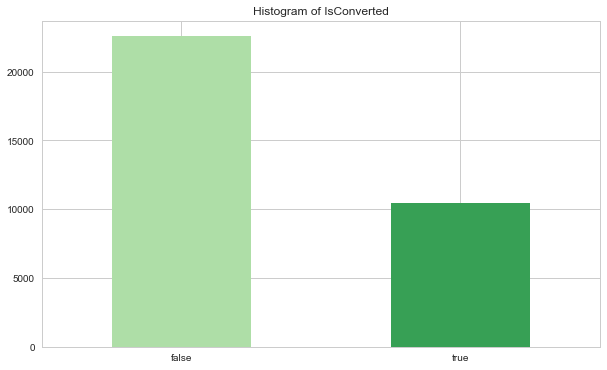

In [44]:
'''

    1) Converted vs not converted:
        * There are more unconverted leads
'''
# Plot IsConverted histogram
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
df_us.IsConverted.value_counts().plot(kind = 'bar', ax = ax, color = sns.color_palette("Greens", n_colors=2))
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 0)
ax.set_title('Histogram of IsConverted')

In [45]:
'''
    2) Leads by source:
        * There are more Marketing leads
        * There is a higher percentage of sales leads that dont convert
'''
source_lead = df_us.groupby(['lead_source_updated']).IsConverted.value_counts()
source_lead.index.levels[1].name = 'converted'
source_lead.columns = ['lead_counts']

In [46]:
source_lead = source_lead.reset_index()

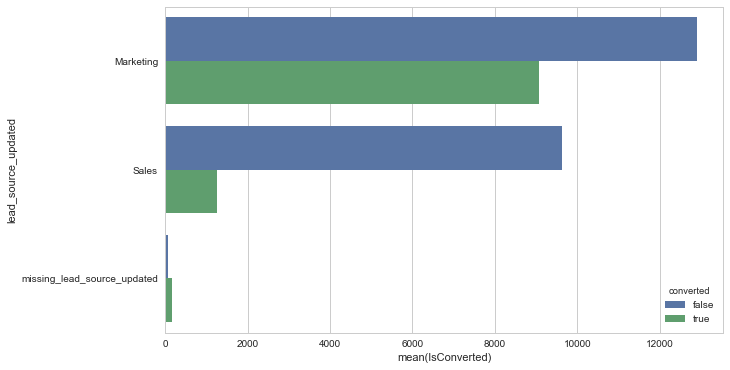

In [47]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
sns.barplot(x = 'IsConverted', y='lead_source_updated', hue = 'converted', data = source_lead,ax=ax)

In [48]:
'''
    3) Leads by industry and source
        * Marketing 'Other' industry leads convert whereas Sales 'Other' leads dont seem to convert as much
'''
ind_lead = df_us.groupby(['grouped_industry','lead_source_updated']).IsConverted.value_counts()

In [49]:
ind_lead.head()

grouped_industry  lead_source_updated          IsConverted
Federal           Marketing                    true           429
                                               false          329
                  Sales                        true            50
                                               false           15
                  missing_lead_source_updated  true             3
Name: IsConverted, dtype: int64

In [50]:
ind_lead = ind_lead.reset_index(level=0)
ind_lead.columns = ['grouped_industry','num_converted']
ind_lead = ind_lead.reset_index()

In [51]:
ind_lead.head()

,lead_source_updated,IsConverted,grouped_industry,num_converted
0,Marketing,true,Federal,429
1,Marketing,false,Federal,329
2,Sales,true,Federal,50
3,Sales,false,Federal,15
4,missing_lead_source_updated,true,Federal,3


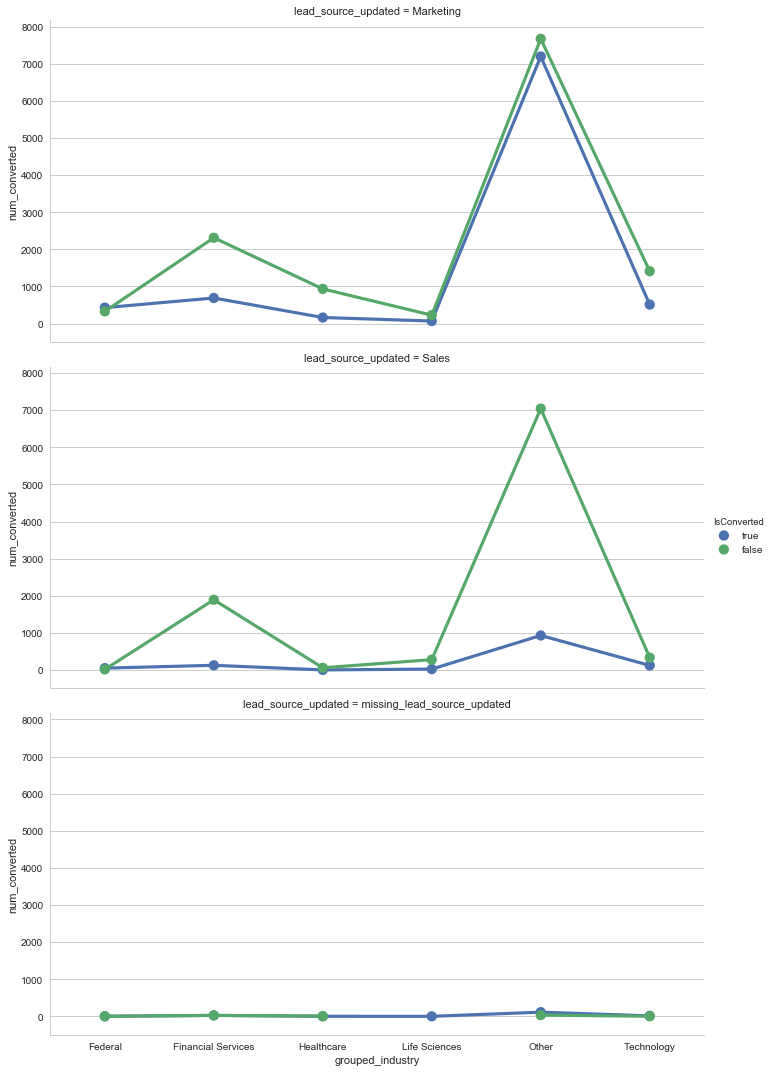

In [52]:
#fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
ax = sns.factorplot(x='grouped_industry',y='num_converted',hue = 'IsConverted', row = 'lead_source_updated', 
                    data = ind_lead,  size=5, aspect=2)

In [53]:
'''
    4) Title score median
'''
title_lead = df_us.groupby(['IsConverted','lead_source_updated','grouped_industry']).Title_Score__c.median().reset_index()
title_lead.head()

,IsConverted,lead_source_updated,grouped_industry,Title_Score__c
0,false,Marketing,Federal,58
1,false,Marketing,Financial Services,60
2,false,Marketing,Healthcare,60
3,false,Marketing,Life Sciences,58
4,false,Marketing,Other,60


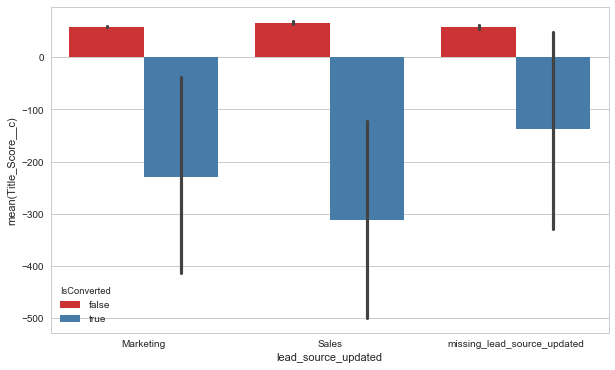

In [54]:
'''
    5) Average title score by lead source:
        * Lead source doesnt seem to affect the title score if dont make missing/null titlescore NEGATIVE (-500)
'''
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
sns.barplot(x = 'lead_source_updated',y = 'Title_Score__c' ,hue = 'IsConverted',
            data = title_lead, ax = ax, palette='Set1')

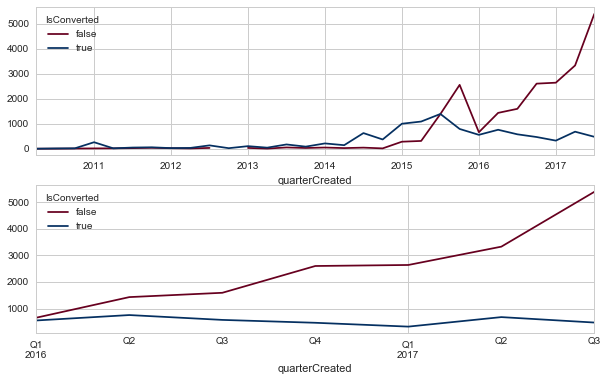

In [55]:
'''
    6) Converted leads by quarter for all data & for after Q1-2016
'''
fig, axes = plt.subplots(ncols=1, nrows=2, figsize = (10,6))
df_us.groupby(['quarterCreated']).IsConverted.value_counts().unstack().plot(ax = axes[0], cmap='RdBu')
df_us[(df_us.quarterCreated >= pd.Period('2016Q1', freq = 'Q-SEP'))].groupby(['quarterCreated']).IsConverted.value_counts().unstack().plot(ax = axes[1], cmap='RdBu')

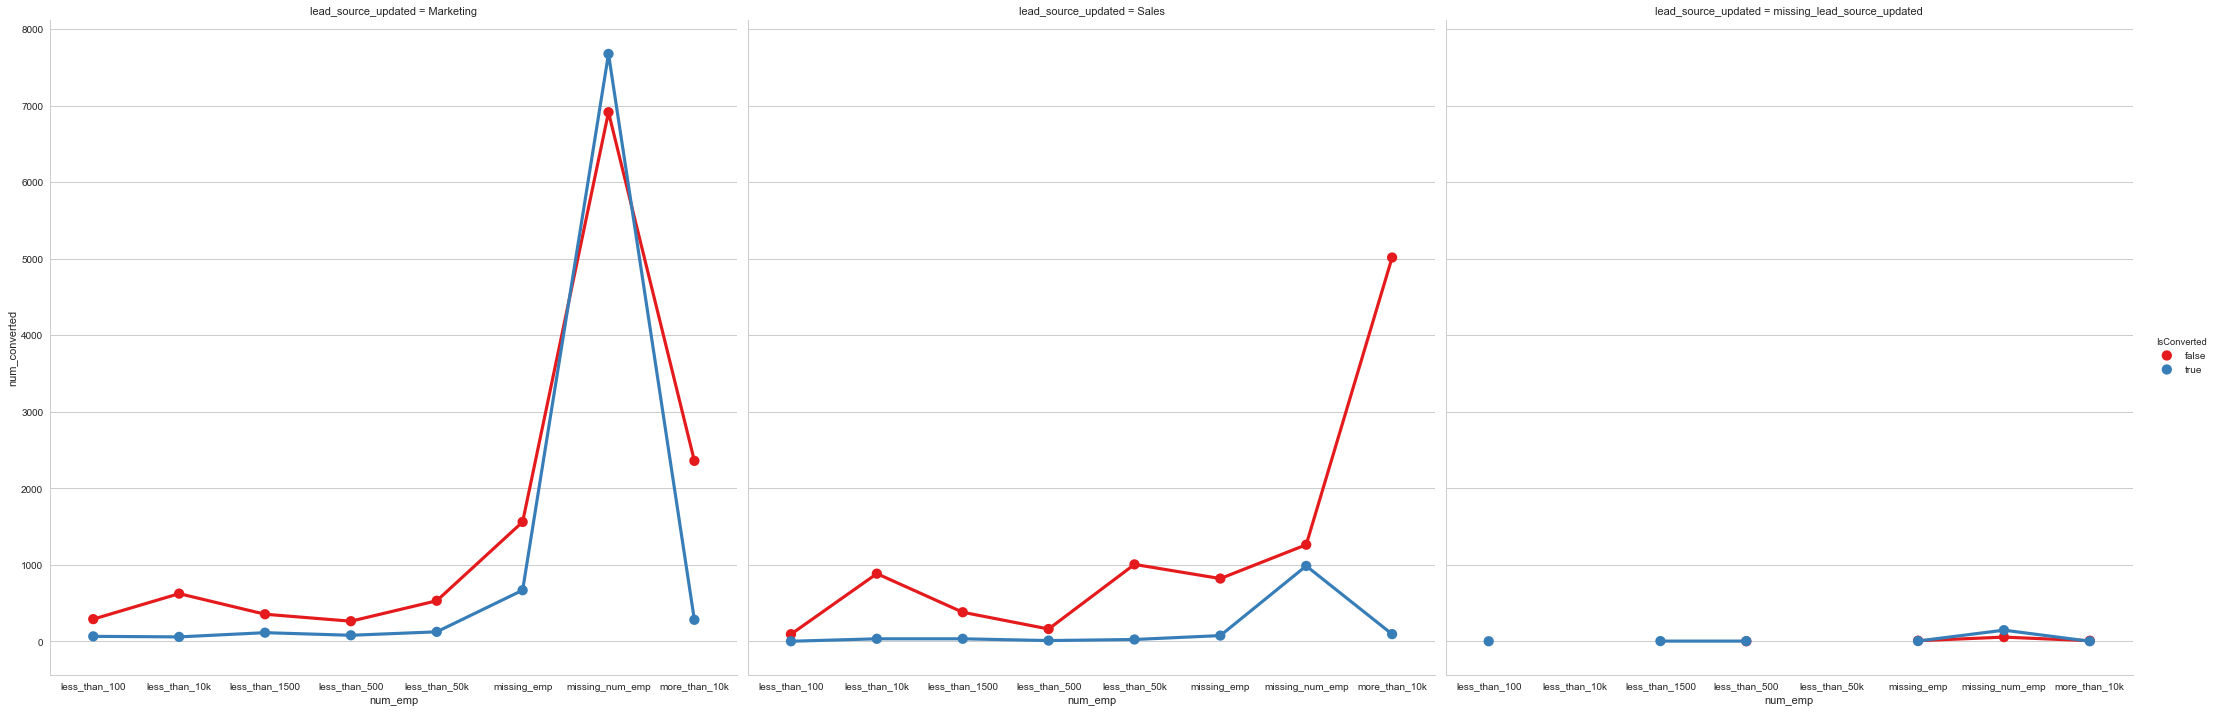

In [60]:
#active_over_2wks_ago
'''
    7) Number of leads converted by company size (employee #)
        Company size seems to matter when the lead source is Sales 
'''
num_emp = df_us.groupby(['lead_source_updated','num_emp']).IsConverted.value_counts()
num_emp = num_emp.reset_index(level=0)
num_emp.columns = ['lead_source_updated','num_converted']

num_emp = num_emp.reset_index()
num_emp.head()

# fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10,6))
sns.factorplot(x = 'num_emp',y = 'num_converted' ,hue = 'IsConverted', col ='lead_source_updated',
            data = num_emp, palette='Set1', size=10, aspect=1)

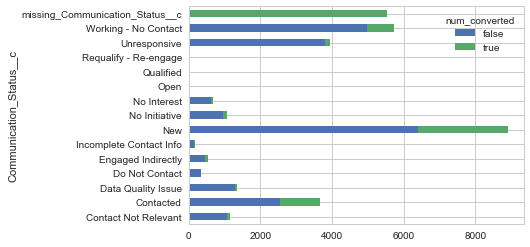

In [61]:
'''
    8) Communication status vs Converted
'''
comm = df_us.groupby(['Communication_Status__c']).IsConverted.value_counts()
comm.index.names = ['Communication_Status__c','num_converted']
comm = comm.unstack()
comm.plot(kind = 'barh',  stacked = True) 

### Feature encoding  - 1st pass

 ** Remove title score and just use title score bins created since there are many title scores missing**
 ** Scaled 'Title','Company','email_sig','LeanData__Reporting_Matched_Account__c' by dividing by 1000**
 ** Used LabelEncoder to encode* TODO: better feature encoding:
    
    **get title levels & scale title**
    
    **do something about email_sig encoding**

    **industry vs industry_wave - keep one**
    
    **company - scale or remove feature**
    

In [243]:
df_transformed = df_us.copy()

In [221]:
df_transformed.IsConverted.value_counts()

false    22581
true     10475
Name: IsConverted, dtype: int64

In [222]:
df_transformed.columns

Index([                              u'LastName',
                                        u'Title',
                               u'Title_Score__c',
                                  u'CreatedDate',
                                  u'IsConverted',
                              u'CurrencyIsoCode',
                         u'Eloqua_Score_Card__c',
                      u'Communication_Status__c',
                 u'Community_Registered_User__c',
                u'University_Registered_User__c',
                        u'University_Steward__c',
                           u'HasOptedOutofEmail',
                                     u'Industry',
                             u'Industry_Wave__c',
                                      u'Company',
                             u'LastActivityDate',
                             u'LastModifiedDate',
                           u'Latest_Campaign__c',
                                 u'Lead_Type__c',
                                   u'LeadSource',


In [244]:
df_transformed = df_transformed.drop(['IsConverted','IsConverted_2',
                                      'CreatedDate','LastActivityDate', 'LastModifiedDate','LastName','Industry',
                                      'grouped_industry','Title_Score__c'], axis =1)

In [225]:
df_transformed.columns

Index([                                 u'Title',
                              u'CurrencyIsoCode',
                         u'Eloqua_Score_Card__c',
                      u'Communication_Status__c',
                 u'Community_Registered_User__c',
                u'University_Registered_User__c',
                        u'University_Steward__c',
                           u'HasOptedOutofEmail',
                             u'Industry_Wave__c',
                                      u'Company',
                           u'Latest_Campaign__c',
                                 u'Lead_Type__c',
                                   u'LeadSource',
       u'LeanData__Reporting_Matched_Account__c',
            u'LeanData_Matched_Account_Owner__c',
                u'LeanData_Matched_US_Region__c',
                                u'Managed_By__c',
                                      u'OwnerId',
                                   u'lead_owner',
                          u'lead_owner_division',


In [227]:
df_transformed.head()

,Title,CurrencyIsoCode,Eloqua_Score_Card__c,Communication_Status__c,Community_Registered_User__c,University_Registered_User__c,University_Steward__c,HasOptedOutofEmail,Industry_Wave__c,Company,...,has_leanData_acct,has_phone,email_sig,email_blacklisted,quarterCreated,missing_firstname,title_score_bin,missing_title,num_emp,job_level
0,Assistant Vice President Information Technolog...,USD,C4,New,false,false,false,false,Other,"General Motors Financial Company, Inc.",...,1,1,americredit.com,0,2015Q4,0,"[40.0, 100.6)",0,less_than_50k,missing_job_level
2,"Director, Data Services",USD,B3,No Interest,false,false,false,false,Insurance,Builders Mutual Ins,...,0,1,bmico.com,0,2012Q2,0,"[40.0, 100.6)",0,missing_emp,missing_job_level
3,"Head, Service and Performance Management",USD,C4,Working - No Contact,false,false,false,false,Life Sciences,Boehringer Ingelheim,...,1,1,boehringer-ingelheim.com,0,2016Q3,0,"[40.0, 100.6)",0,less_than_10k,missing_job_level
4,global risk governance manager,USD,B4,Working - No Contact,false,false,false,false,Insurance,AFLAC Incorporated,...,1,1,aflac.com,0,2015Q3,0,"[40.0, 100.6)",0,less_than_10k,manager
5,Director,USD,B4,New,false,false,false,false,Education,MIT CDOIQ Program,...,1,1,mit.edu,0,2015Q4,0,"[40.0, 100.6)",0,more_than_10k,missing_job_level


In [245]:
# find categorical columns to encode
cat_columns = df_transformed.select_dtypes(include = ['object','category']).columns

In [230]:
cat_columns

Index([                                 u'Title',
                              u'CurrencyIsoCode',
                         u'Eloqua_Score_Card__c',
                      u'Communication_Status__c',
                 u'Community_Registered_User__c',
                u'University_Registered_User__c',
                        u'University_Steward__c',
                           u'HasOptedOutofEmail',
                             u'Industry_Wave__c',
                                      u'Company',
                           u'Latest_Campaign__c',
                                 u'Lead_Type__c',
                                   u'LeadSource',
       u'LeanData__Reporting_Matched_Account__c',
            u'LeanData_Matched_Account_Owner__c',
                u'LeanData_Matched_US_Region__c',
                                u'Managed_By__c',
                                      u'OwnerId',
                                   u'lead_owner',
                          u'lead_owner_division',


In [246]:
le = LabelEncoder()
# encode labels using label encoder
for col in cat_columns:
    df_transformed[col] = le.fit_transform(df_transformed[col])


In [247]:
df_transformed.describe()

,Title,CurrencyIsoCode,Eloqua_Score_Card__c,Communication_Status__c,Community_Registered_User__c,University_Registered_User__c,University_Steward__c,HasOptedOutofEmail,Industry_Wave__c,Company,...,has_leanData_acct,has_phone,email_sig,email_blacklisted,quarterCreated,missing_firstname,title_score_bin,missing_title,num_emp,job_level
count,33056.000000,33056.000000,33056.000000,33056.000000,33056.000000,33056.000000,33056.000000,33056.000000,33056.000000,33056.000000,...,33056.000000,33056.000000,33056.000000,33056.000000,33056.000000,33056.0,33056.000000,33056.0,33056.000000,33056.000000
mean,8617.534124,4.627571,11.125605,8.339727,0.003207,0.004659,0.000242,0.026652,15.952717,5502.805845,...,0.592570,0.965332,3240.036937,0.079229,24.092963,0.0,1.493314,0.0,5.560806,5.816372
std,5380.178746,0.988116,4.057857,4.788306,0.056538,0.068097,0.015555,0.161066,6.362534,3351.924374,...,0.491363,0.182941,2009.879953,0.270100,4.822818,0.0,0.861424,0.0,1.614653,0.841543
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
25%,3364.000000,5.000000,7.000000,6.000000,0.000000,0.000000,0.000000,0.000000,13.000000,2495.000000,...,0.000000,1.000000,1497.000000,0.000000,22.000000,0.0,1.000000,0.0,5.000000,6.000000
50%,8434.500000,5.000000,11.000000,7.000000,0.000000,0.000000,0.000000,0.000000,19.000000,5361.000000,...,1.000000,1.000000,2979.000000,0.000000,25.000000,0.0,2.000000,0.0,6.000000,6.000000
75%,13160.000000,5.000000,15.000000,13.000000,0.000000,0.000000,0.000000,0.000000,19.000000,8305.000000,...,1.000000,1.000000,4904.000000,0.000000,28.000000,0.0,2.000000,0.0,6.000000,6.000000
max,18548.000000,5.000000,16.000000,14.000000,1.000000,1.000000,1.000000,1.000000,25.000000,11719.000000,...,1.000000,1.000000,6813.000000,1.000000,29.000000,0.0,2.000000,0.0,7.000000,7.000000


In [249]:
# fix scaling - divide columns by 1000
df_transformed[['Title','Company','email_sig','LeanData__Reporting_Matched_Account__c']] = df_transformed[['Title','Company','email_sig','LeanData__Reporting_Matched_Account__c']].apply(lambda x:x/1000)

In [275]:
for c in df_transformed.columns:
    print c, 'max ', df_transformed[c].max(), ' min ', df_transformed[c].min(), 'avg', df_transformed[c].median()

Title max  18.548  min  0.0 avg 8.4345
CurrencyIsoCode max  5  min  0 avg 5.0
Eloqua_Score_Card__c max  16  min  0 avg 11.0
Communication_Status__c max  14  min  0 avg 7.0
Community_Registered_User__c max  1  min  0 avg 0.0
University_Registered_User__c max  1  min  0 avg 0.0
University_Steward__c max  1  min  0 avg 0.0
HasOptedOutofEmail max  1  min  0 avg 0.0
Industry_Wave__c max  25  min  0 avg 19.0
Company max  11.719  min  0.0 avg 5.361
Latest_Campaign__c max  419  min  0 avg 340.0
Lead_Type__c max  7  min  0 avg 3.0
LeadSource max  24  min  0 avg 18.0
LeanData__Reporting_Matched_Account__c max  2.428  min  0.0 avg 1.777
LeanData_Matched_Account_Owner__c max  49  min  0 avg 32.0
LeanData_Matched_US_Region__c max  5  min  0 avg 4.0
Managed_By__c max  2  min  0 avg 0.0
OwnerId max  51  min  0 avg 16.0
lead_owner max  51  min  0 avg 24.0
lead_owner_division max  10  min  0 avg 7.0
lead_owner_dept max  10  min  0 avg 6.0
lead_source_updated max  2  min  0 avg 0.0
has_leanData_acct max

In [295]:
#df_transformed = df_transformed.drop(cols_drop,axis=1)
X, y = shuffle(df_transformed, df_us.IsConverted_2 , random_state=23)

'''
FEATURE IMPORTANCE USING DECISION TREE
'''
# split data into training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.15, random_state=1)


# create decision tree model and fit to training data set to obtain feature importance
tree_model = tree.DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=10,min_samples_leaf=5)
#tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
# predict test 
tree_predicted = tree_model.predict(X_test)

In [296]:
tree_impt = tree_model.feature_importances_
# get sorted index 
sorted_idx_tree = np.argsort(tree_impt)
# Print feature importance sorted by most important
for f in xrange(len(X.columns),0,-1):
    print("%d. feature %d (%f)  %s" % (f , sorted_idx_tree[f-1], tree_impt[sorted_idx_tree[f-1]], X.columns[sorted_idx_tree[f-1]]))


32. feature 28 (0.931174)  title_score_bin
31. feature 12 (0.027602)  LeadSource
30. feature 2 (0.013535)  Eloqua_Score_Card__c
29. feature 21 (0.007659)  lead_source_updated
28. feature 17 (0.007086)  OwnerId
27. feature 11 (0.004813)  Lead_Type__c
26. feature 18 (0.003364)  lead_owner
25. feature 10 (0.003031)  Latest_Campaign__c
24. feature 19 (0.001124)  lead_owner_division
23. feature 24 (0.000613)  email_sig
22. feature 9 (0.000000)  Company
21. feature 8 (0.000000)  Industry_Wave__c
20. feature 31 (0.000000)  job_level
19. feature 7 (0.000000)  HasOptedOutofEmail
18. feature 5 (0.000000)  University_Registered_User__c
17. feature 4 (0.000000)  Community_Registered_User__c
16. feature 3 (0.000000)  Communication_Status__c
15. feature 1 (0.000000)  CurrencyIsoCode
14. feature 6 (0.000000)  University_Steward__c
13. feature 15 (0.000000)  LeanData_Matched_US_Region__c
12. feature 13 (0.000000)  LeanData__Reporting_Matched_Account__c
11. feature 14 (0.000000)  LeanData_Matched_Accou

In [299]:
'''
    Cross validation using cross_val_score - one parameter at a time
'''
from sklearn.cross_validation import cross_val_score
x = df_transformed
y = df_us.IsConverted_2

depth = []

for i in range(3,20):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    # Perform 7-fold cross validation 
    scores = cross_val_score(estimator=clf, X=x, y=y, cv=7, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

[(3, 0.92177037957769048), (4, 0.89478702842436497), (5, 0.89896205978497734), (6, 0.90537398772490263), (7, 0.90053478822439215), (8, 0.90171451563420291), (9, 0.90600993960577259), (10, 0.89620703488008624), (11, 0.89678226195494337), (12, 0.8948763218990774), (13, 0.8851650109410395), (14, 0.88816000097531178), (15, 0.88014302189203342), (16, 0.87578653355120395), (17, 0.8733663796265605), (18, 0.86804181049861007), (19, 0.86704346338394678)]


In [301]:
'''
    Cross validation using Grid Search - for best parameters
'''
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20), 'min_samples_leaf':range(5,15) }
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X=x, y=y)
tree_model = clf.best_estimator_

print (clf.best_score_, clf.best_params_) 

(0.82215029041626331, {'min_samples_split': 5, 'max_depth': 3, 'min_samples_leaf': 5})


In [314]:
'''
FEATURE IMPORTANCE USING DECISION TREE
'''

X, y = shuffle(df_transformed, df_us.IsConverted_2 , random_state=23)
# split data into training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.20, random_state=1)


# create decision tree model and fit to training data set to obtain feature importance
tree_model = tree.DecisionTreeClassifier(max_depth = clf.best_params_['max_depth'], 
                                         min_samples_split = clf.best_params_['min_samples_split'],
                                        min_samples_leaf= clf.best_params_['min_samples_leaf'])
#tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
# predict test 
tree_predicted = tree_model.predict(X_test)

In [316]:
tree_impt = tree_model.feature_importances_
# get sorted index 
sorted_idx_tree = np.argsort(tree_impt)
# Print feature importance sorted by most important
for f in xrange(len(X.columns),0,-1):
    print("%d. feature %d (%f)  %s" % (f , sorted_idx_tree[f-1], tree_impt[sorted_idx_tree[f-1]], X.columns[sorted_idx_tree[f-1]]))


32. feature 28 (0.956501)  title_score_bin
31. feature 12 (0.028352)  LeadSource
30. feature 21 (0.007868)  lead_source_updated
29. feature 17 (0.007278)  OwnerId
28. feature 7 (0.000000)  HasOptedOutofEmail
27. feature 11 (0.000000)  Lead_Type__c
26. feature 10 (0.000000)  Latest_Campaign__c
25. feature 9 (0.000000)  Company
24. feature 8 (0.000000)  Industry_Wave__c
23. feature 31 (0.000000)  job_level
22. feature 13 (0.000000)  LeanData__Reporting_Matched_Account__c
21. feature 5 (0.000000)  University_Registered_User__c
20. feature 4 (0.000000)  Community_Registered_User__c
19. feature 3 (0.000000)  Communication_Status__c
18. feature 2 (0.000000)  Eloqua_Score_Card__c
17. feature 1 (0.000000)  CurrencyIsoCode
16. feature 6 (0.000000)  University_Steward__c
15. feature 15 (0.000000)  LeanData_Matched_US_Region__c
14. feature 14 (0.000000)  LeanData_Matched_Account_Owner__c
13. feature 30 (0.000000)  num_emp
12. feature 16 (0.000000)  Managed_By__c
11. feature 18 (0.000000)  lead_ow

In [317]:
# Decision Tree performance
print "Decision Tree score is: ", tree_model.score(X_test, y_test)

# Classification Report
print "\nClassification Report:\n"
print (classification_report(y_test, tree_predicted))

# Confustion Matrix
print "Confustion Matrix:" 
print(get_confusion_matrix(y_test, tree_predicted))

print confusion_matrix(y_true=y_test,y_pred=tree_predicted)

Decision Tree score is:  0.931034482759

Classification Report:

             precision    recall  f1-score   support

          0       0.92      0.98      0.95      3365
          1       0.95      0.83      0.89      1594

avg / total       0.93      0.93      0.93      4959

Confustion Matrix:
                     NotConverted-Predicted  Converted-Predicted
NotConverted-Actual                    3297                   68
Converted-Actual                        274                 1320
[[3297   68]
 [ 274 1320]]


In [323]:
import subprocess
from sklearn.tree import export_graphviz
import pydotplus 
from IPython.display import Image

#### Visualize decision tree splitting based on which features

In [329]:
features = list(df_transformed.columns)
# create dot file
dot_data = tree.export_graphviz(tree_model, out_file=None, feature_names= features)

In [347]:
graph = pydotplus.graph_from_dot_data(dot_data.encode('utf-8')) 

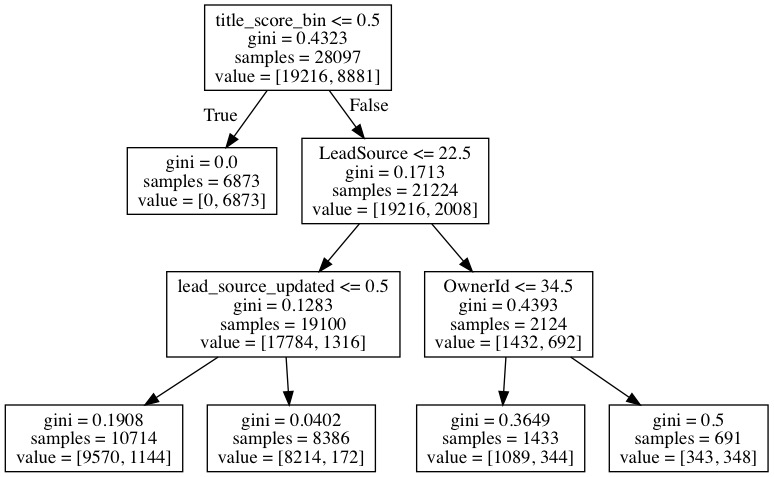

In [353]:

Image(graph.create_jpeg()) 

In [434]:
# from sklearn.preprocessing import LabelBinarizer
lb_style = LabelBinarizer()

In [466]:
add_df = pd.DataFrame()
cols_encode = ['job_level','lead_source_updated',
               'Lead_Type__c','Eloqua_Score_Card__c','num_emp']
for c in cols_encode:
    lb_results = lb_style.fit_transform(df_transformed[c])
    print c, len(lb_style.classes_)
    temp = pd.DataFrame(lb_results, columns=lb_style.classes_)
    print temp.head()
    add_df = pd.concat([add_df, temp],axis=1)

job_level 8
   c-level  consultant  department head  director  individual contributer  \
0        0           0                0         0                       0   
1        0           0                0         0                       0   
2        0           0                0         0                       0   
3        0           0                0         0                       0   
4        0           0                0         0                       0   

   manager  missing_job_level  vp  
0        0                  1   0  
1        0                  1   0  
2        0                  1   0  
3        1                  0   0  
4        0                  1   0  
lead_source_updated 3
   Marketing  Sales  missing_lead_source_updated
0          0      1                            0
1          1      0                            0
2          0      1                            0
3          0      1                            0
4          1      0                       

In [462]:
add_df.shape

(32278, 66)

In [467]:
# add columns
for col in add_df.columns:
    print col
    df_transformed[str(col)] = add_df[col]
    nulls = df_transformed[col].isnull().sum()
    if nulls>0:
        df_transformed[col] = df_transformed[col].fillna(2.0)

c-level
consultant
department head
director
individual contributer
manager
missing_job_level
vp
Marketing
Sales
missing_lead_source_updated
Competitor
Consulting Partner
Customer
Prospect
Prospects
Researcher
Technology Partner
missing_Lead_Type__c
A1
A2
A3
A4
B1
B2
B3
B4
C1
C2
C3
C4
D1
D2
D3
D4
missing_Eloqua_Score_Card__c
less_than_100
less_than_10k
less_than_1500
less_than_500
less_than_50k
missing_emp
missing_num_emp
more_than_10k


In [469]:
print df_transformed.columns
add_df[col].isnull().sum()

Index([                              u'LastName',
                                        u'Title',
                               u'Title_Score__c',
                              u'CurrencyIsoCode',
                         u'Eloqua_Score_Card__c',
                      u'Communication_Status__c',
                 u'Community_Registered_User__c',
                u'University_Registered_User__c',
                        u'University_Steward__c',
                           u'HasOptedOutofEmail',
                                     u'Industry',
                             u'Industry_Wave__c',
                                      u'Company',
                           u'Latest_Campaign__c',
                                 u'Lead_Type__c',
                                   u'LeadSource',
       u'LeanData__Reporting_Matched_Account__c',
            u'LeanData_Matched_Account_Owner__c',
                u'LeanData_Matched_US_Region__c',
                                u'Managed_By__c',


0

In [252]:
df_transformed.head()

,Title,CurrencyIsoCode,Eloqua_Score_Card__c,Communication_Status__c,Community_Registered_User__c,University_Registered_User__c,University_Steward__c,HasOptedOutofEmail,Industry_Wave__c,Company,...,has_leanData_acct,has_phone,email_sig,email_blacklisted,quarterCreated,missing_firstname,title_score_bin,missing_title,num_emp,job_level
0,0.544,5,11,6,0,0,0,0,19,4.375,...,1,1,0.352,0,22,0,2,0,4,6
2,4.736,5,6,8,0,0,0,0,13,1.655,...,0,1,0.900,0,8,0,2,0,5,6
3,7.235,5,11,13,0,0,0,0,14,1.521,...,1,1,0.923,0,25,0,2,0,1,6
4,17.197,5,7,13,0,0,0,0,13,0.108,...,1,1,0.187,0,21,0,2,0,1,5
5,3.364,5,7,6,0,0,0,0,5,6.226,...,1,1,4.043,0,22,0,2,0,7,6


In [471]:
for x in cols_encode:
    try:
        df_transformed.drop(x,axis =1,inplace=True)
    except:
        print "no column", x

In [472]:
df_transformed.columns

Index([                              u'LastName',
                                        u'Title',
                               u'Title_Score__c',
                              u'CurrencyIsoCode',
                      u'Communication_Status__c',
                 u'Community_Registered_User__c',
                u'University_Registered_User__c',
                        u'University_Steward__c',
                           u'HasOptedOutofEmail',
                                     u'Industry',
                             u'Industry_Wave__c',
                                      u'Company',
                           u'Latest_Campaign__c',
                                   u'LeadSource',
       u'LeanData__Reporting_Matched_Account__c',
            u'LeanData_Matched_Account_Owner__c',
                u'LeanData_Matched_US_Region__c',
                                u'Managed_By__c',
                                      u'OwnerId',
                                   u'lead_owner',


In [473]:
# find categorical columns to encode
cat_columns = df_transformed.select_dtypes(include = ['object','category']).columns

In [474]:
cat_columns

Index([                              u'LastName',
                                        u'Title',
                              u'CurrencyIsoCode',
                      u'Communication_Status__c',
                 u'Community_Registered_User__c',
                u'University_Registered_User__c',
                        u'University_Steward__c',
                           u'HasOptedOutofEmail',
                                     u'Industry',
                             u'Industry_Wave__c',
                                      u'Company',
                           u'Latest_Campaign__c',
                                   u'LeadSource',
       u'LeanData__Reporting_Matched_Account__c',
            u'LeanData_Matched_Account_Owner__c',
                u'LeanData_Matched_US_Region__c',
                                u'Managed_By__c',
                                      u'OwnerId',
                                   u'lead_owner',
                          u'lead_owner_division',


In [475]:
le = LabelEncoder()
# encode labels
for col in cat_columns:
    df_transformed[col] = le.fit_transform(df_transformed[col])


In [476]:
df_transformed.dtypes

LastName                                    int64
Title                                       int64
Title_Score__c                              int64
CurrencyIsoCode                             int64
Communication_Status__c                     int64
Community_Registered_User__c                int64
University_Registered_User__c               int64
University_Steward__c                       int64
HasOptedOutofEmail                          int64
Industry                                    int64
Industry_Wave__c                            int64
Company                                     int64
Latest_Campaign__c                          int64
LeadSource                                  int64
LeanData__Reporting_Matched_Account__c      int64
LeanData_Matched_Account_Owner__c           int64
LeanData_Matched_US_Region__c               int64
Managed_By__c                               int64
OwnerId                                     int64
lead_owner                                  int64


In [217]:
# make sure no nulls
np.any(df_transformed.isnull())

False

In [478]:
len(df_transformed.Title.unique()) #.iloc[0:10, 10:]

18118

In [301]:
# TODO: better feature encoding as the difference in ranges may be affecting model
df_transformed.Title.value_counts()[0:10]

3276     481
8154     395
2542     322
9546     314
2198     282
14806    194
14145    188
412      178
5682     148
5633     144
Name: Title, dtype: int64

In [253]:
df_transformed.head()

,Title,CurrencyIsoCode,Eloqua_Score_Card__c,Communication_Status__c,Community_Registered_User__c,University_Registered_User__c,University_Steward__c,HasOptedOutofEmail,Industry_Wave__c,Company,...,has_leanData_acct,has_phone,email_sig,email_blacklisted,quarterCreated,missing_firstname,title_score_bin,missing_title,num_emp,job_level
0,0.544,5,11,6,0,0,0,0,19,4.375,...,1,1,0.352,0,22,0,2,0,4,6
2,4.736,5,6,8,0,0,0,0,13,1.655,...,0,1,0.900,0,8,0,2,0,5,6
3,7.235,5,11,13,0,0,0,0,14,1.521,...,1,1,0.923,0,25,0,2,0,1,6
4,17.197,5,7,13,0,0,0,0,13,0.108,...,1,1,0.187,0,21,0,2,0,1,5
5,3.364,5,7,6,0,0,0,0,5,6.226,...,1,1,4.043,0,22,0,2,0,7,6


In [218]:
# reshuffle data
cols_drop = ['Title_Score__c'] #,'Industry','email_sig','lead_owner_dept']
cols_drop = ['Title_Score__c','title_score_bin','email_sig','FirstName','LastName','email','LeadSource',
             'grouped_industry', 'Industry',
             'LeanData__Reporting_Matched_Account__c', 'OwnerId','Phone']
#df_transformed = df_transformed.drop(cols_drop,axis=1)
X, y = shuffle(df_transformed.drop(['LastName'], axis=1) , df_us.IsConverted_2 , random_state=23)

'''
FEATURE IMPORTANCE USING DECISION TREE
'''
# split data into training and test sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.15, random_state=1)


# create decision tree model and fit to training data set to obtain feature importance
tree_model = tree.DecisionTreeClassifier(criterion='gini')
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
# predict test 
tree_predicted = tree_model.predict(X_test)

ValueError: could not convert string to float: manager

In [481]:
tree_impt = tree_model.feature_importances_
# get sorted index 
sorted_idx_tree = np.argsort(tree_impt)
# Print feature importance sorted by most important
for f in xrange(len(X.columns),0,-1):
    print("%d. feature %d (%f)  %s" % (f , sorted_idx_tree[f-1], tree_impt[sorted_idx_tree[f-1]], X.columns[sorted_idx_tree[f-1]]))


78. feature 41 (0.787726)  G&A
77. feature 27 (0.081994)  active_over_2wks_ago
76. feature 26 (0.033616)  quarterCreated
75. feature 12 (0.017723)  LeadSource
74. feature 11 (0.008936)  Latest_Campaign__c
73. feature 3 (0.007596)  Communication_Status__c
72. feature 0 (0.007424)  Title
71. feature 24 (0.005710)  email_sig
70. feature 1 (0.005176)  Title_Score__c
69. feature 13 (0.004375)  LeanData__Reporting_Matched_Account__c
68. feature 20 (0.004260)  lead_owner_dept
67. feature 16 (0.003680)  Managed_By__c
66. feature 14 (0.003668)  LeanData_Matched_Account_Owner__c
65. feature 21 (0.003142)  grouped_industry
64. feature 18 (0.003103)  lead_owner
63. feature 17 (0.002750)  OwnerId
62. feature 10 (0.002632)  Company
61. feature 19 (0.002187)  lead_owner_division
60. feature 8 (0.001915)  Industry
59. feature 15 (0.001515)  LeanData_Matched_US_Region__c
58. feature 9 (0.001261)  Industry_Wave__c
57. feature 52 (0.000974)  missing_Lead_Type__c
56. feature 69 (0.000855)  missing_Eloqua_

In [482]:
# Decision Tree performance
print "Decision Tree score is: ", tree_model.score(X_test, y_test)

# Classification Report
print "\nClassification Report:\n"
print (classification_report(y_test, tree_predicted))

# Confustion Matrix
print "Confustion Matrix:" 
print(get_confusion_matrix(y_test, tree_predicted))

print confusion_matrix(y_true=y_test,y_pred=tree_predicted)

Decision Tree score is:  0.983064849236

Classification Report:

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      3321
          1       0.97      0.98      0.97      1521

avg / total       0.98      0.98      0.98      4842

Confustion Matrix:
                     NotConverted-Predicted  Converted-Predicted
NotConverted-Actual                    3273                   48
Converted-Actual                         34                 1487
[[3273   48]
 [  34 1487]]


In [483]:
# reshuffle data
X, y = shuffle(df_transformed ,df_us.IsConverted, random_state=13)

In [484]:
'''
Random Forest Classifier 
'''
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.20, random_state=1)

rf = RandomForestClassifier(n_estimators = 1500)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

In [485]:
# Random Forest performance
print "Random Forest score is: ", rf.score(X_test, y_test)

# Classification Report
print "\nClassification Report:\n"
print (classification_report(y_test, rf_predicted))

# Confustion Matrix
print "Confustion Matrix:" 
print(get_confusion_matrix(y_test, rf_predicted))

Random Forest score is:  0.986988847584

Classification Report:

             precision    recall  f1-score   support

      false       0.99      0.99      0.99      4401
       true       0.99      0.97      0.98      2055

avg / total       0.99      0.99      0.99      6456

Confustion Matrix:
                     NotConverted-Predicted  Converted-Predicted
NotConverted-Actual                    4378                   23
Converted-Actual                         61                 1994


In [ ]:
## select best columns and see how it does
best_cols = [X.columns[sorted_idx_tree[i-1]] for i in xrange(12,6,-1)]

### Model 2: Logistic Regression

In [488]:
# reshuffle data
X, y = shuffle(df_transformed ,df_us.IsConverted, random_state=1)

In [525]:
'''
    Logistic Regression
'''
# training and testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1)

logreg = LogisticRegression(random_state=123, verbose=1)

#Cs = np.logspace(-7, 5, num=15)
logreg = LogisticRegression(C=10.0)
logreg.fit(X_train,y_train)
logreg_predicted = logreg.predict(X_test)
# Logistic Regression performance
print "\nC is ", c, "Logistic Regression score is: ", logreg.score(X_test, y_test)

# Classification Report
print "\nClassification Report:\n"
print (classification_report(y_test, logreg_predicted))

# Confustion Matrix
print "Confustion Matrix:" 
print(get_confusion_matrix(y_test, logreg_predicted))


C is  100000.0 Logistic Regression score is:  0.972893432466

Classification Report:

             precision    recall  f1-score   support

      false       0.98      0.99      0.98      4432
       true       0.97      0.95      0.96      2024

avg / total       0.97      0.97      0.97      6456

Confustion Matrix:
                     NotConverted-Predicted  Converted-Predicted
NotConverted-Actual                    4368                   64
Converted-Actual                        111                 1913


In [526]:
np.exp(logreg.coef_)

array([[ 1.00001002,  0.99996262,  0.98523904,  0.91122379,  0.90644929,
         1.06421355,  0.97519062,  0.99030628,  0.93345828,  0.99658376,
         1.0714618 ,  1.00000563,  0.99558422,  1.07221197,  1.00003776,
         1.00327178,  0.91291061,  0.61345716,  1.03092771,  1.00464474,
         1.18448198,  0.68998318,  0.740787  ,  1.36523431,  1.07827606,
         1.00004399,  0.70894479,  1.05728393,  0.0156038 ,  0.98726016,
         1.        ,  1.        ,  1.07290638,  1.05697982,  1.072314  ,
         1.06139017,  1.07579906,  1.04756412,  0.95218581,  1.06331645,
         1.06294453,  1.06312987,  1.07490969,  1.04313252,  0.94081056,
         1.10376122,  1.03782788,  0.95074782,  1.12640515,  0.91519394,
         1.06322241,  1.07193746,  1.12254967,  1.13168094,  1.06353597,
         1.05955709,  1.14598912,  1.04346076,  1.06362187,  1.06857241,
         1.37656219,  0.82565286,  1.05973125,  1.01597981,  1.50804381,
         0.86734863,  1.05970431,  1.0447166 ,  1.1

In [523]:
logreg.verbose = 1
logreg.verbose

1